# Check results of CMA/ES optimisation using geometric mean of LL

This could give better results than the mean of LL90, which overrepresented nitems=1.

Bays09 dataset

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from experimentlauncher import ExperimentLauncher
from dataio import DataIO
import plots_experimental_data
import em_circularmixture_parametrickappa


# import matplotlib.animation as plt_anim
from mpl_toolkits.mplot3d import Axes3D

import re
import inspect
import imp

import utils
# import submitpbs
import load_experimental_data

In [18]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.graph_objs import Scatter, Figure, Layout
init_notebook_mode(connected=True)


In [4]:
from IPython.html import widgets # Widget definitions
from IPython.display import display # Used to display widgets in the notebook
from IPython.html.widgets import interact
from plotly.widgets import GraphWidget 

/nfs/nhome/live/lmatthey/Applications/anaconda/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning:

The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.

/nfs/nhome/live/lmatthey/Applications/anaconda/lib/python2.7/site-packages/IPython/utils/traitlets.py:5: UserWarning:

IPython.utils.traitlets has moved to a top-level traitlets package.



<IPython.core.display.Javascript object>

## Reload data

In [5]:
%cd cmaes_bays09_prodLL_try1_Mratiosigmaxlapserate_repetitions5_231215

/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_cmaes_11_2015/cmaes_bays09_prodLL_try1_Mratiosigmaxlapserate_repetitions5_231215


In [6]:
results_optim_tracking = np.load('outputs/cmaes_alliter_tracking-<module>-b3247c4e-4797-4736-95e0-4111452edf16.npy').item()

In [7]:
candidates_parameters = np.array(results_optim_tracking['candidates'])
fitness = np.array(results_optim_tracking['fitness'])
parameter_names_sorted = results_optim_tracking['parameter_names_sorted']

In [8]:
parameter_names_sorted

['ratio_conj', 'M', 'sigmax', 'lapse_rate']

In [9]:
df_all_fits = pd.DataFrame.from_items([('step', np.arange(fitness.size)),
                             ('ratio_conj', candidates_parameters[:, 0]),
                             ('M', candidates_parameters[:, 1]),
                             ('sigmax', candidates_parameters[:, 2]),
                             ('lapse_rate', candidates_parameters[:, 3]),
                             ('dist_prodgeomll', np.ma.masked_greater(fitness, 1e8)),
                            ])

In [10]:
# Filter rows where LL > cutoff value and remove lapse_rate > cutoff
LL_max_cutoff = 20000

df_best_fits = df_all_fits[df_all_fits.dist_prodgeomll < LL_max_cutoff]

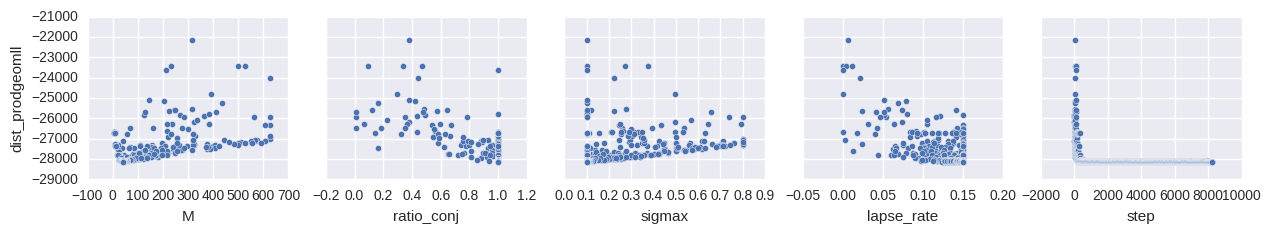

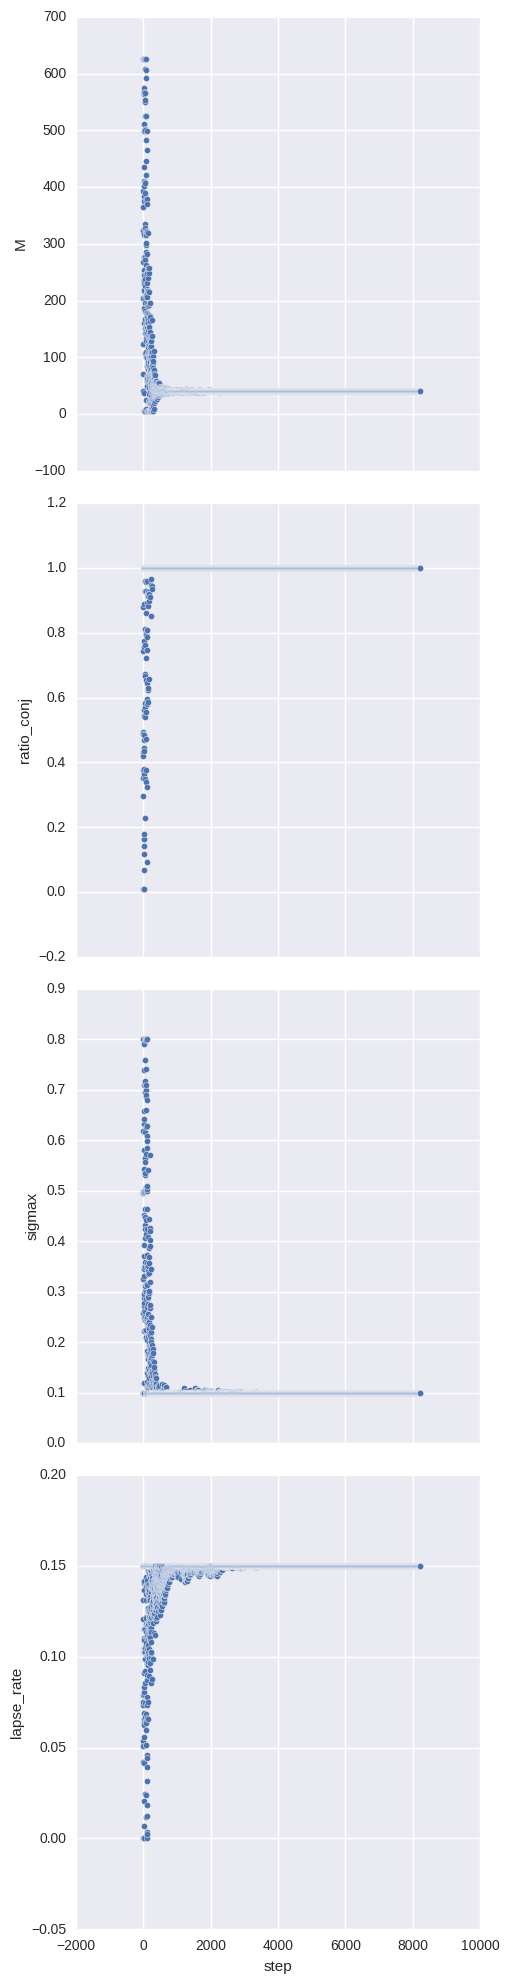

In [11]:
# Check parameters effects
sns.pairplot(df_best_fits,
             x_vars=['M', 'ratio_conj', 'sigmax', 'lapse_rate', 'step'],
             y_vars=['dist_prodgeomll']
            )

# Check learning
sns.pairplot(df_best_fits,
             y_vars=['M', 'ratio_conj', 'sigmax', 'lapse_rate'],
             x_vars=['step'],
             size=5
            )

## Plotly Scatter3D

In [12]:
df_best_fits.columns

Index([u'step', u'ratio_conj', u'M', u'sigmax', u'lapse_rate',
       u'dist_prodgeomll'],
      dtype='object')

In [19]:
result_to_color = np.array(df_best_fits.dist_prodgeomll)

col_min = np.min(result_to_color)
col_max = np.max(result_to_color)

text = ['> %s' % (x) for x in result_to_color]

trace1 = Scatter3d(
        x= df_best_fits.M,
        y= df_best_fits.ratio_conj,
        z= df_best_fits.sigmax,
        text= text,
        mode= 'markers',
        marker= Marker(
            color = result_to_color,
            size = 7,
            colorscale='Bluered',
            cmin=col_min,
            cmax=col_max,
            cauto=False
        )
    )
data = Data([trace1])
layout = Layout(
    title='Landscape for NLL90',
    scene=Scene(
        xaxis=XAxis(
            title='M',
        ),
        yaxis=YAxis(
            title='ratio_conj',
        ),
        zaxis=ZAxis(
            title='sigmax',
        )
    )
)
fig = Figure(data=data, layout=layout)
iplot(fig)

In [21]:
dropdown_space = parameter_names_sorted
dropdown_default = 'lapse_rate'
metric_color_space = ['dist_prodgeomll']
metric_color_default = 'dist_prodgeomll'

g = GraphWidget(scatter3d_url)

class shifter:
    def __init__(self):
        self.slider_index = 0
        self.marker_size = 8
        self.filter_results = slice(None, None)
        self.metric_color = metric_color_default
        self.dropdown_value = dropdown_default
        
        self.change_color_source(metric_color_default)
        self.change_dropdown_value(dropdown_default)
    
    def change_dropdown_value(self, new_value):
        self.dropdown_value = new_value
        
        # Update the axes
        self.axes_parameters = dropdown_space[:]
        self.axes_parameters.remove(self.dropdown_value)
        
        # Update the grid of the dropdown parameter
        self.dropparam_gridified, self.dropparam_gridspace, self.dropparam_midspace = utils.gridify(df_best_fits[self.dropdown_value], bins=10)
        
        
    
    def change_color_source(self, new_value):
        self.metric_color = new_value
        self.result_to_color = np.array(df_best_fits[self.metric_color])
        self.result_to_color[self.result_to_color > 2*np.median(self.result_to_color)] = np.median(self.result_to_color)
        self.col_min = np.min(self.result_to_color)
        self.col_max = np.max(self.result_to_color)
    
    def on_color_source_change(self, name, old_value, new_value):
        self.change_color_source(new_value)
        self.replot()
    
    def on_dropdown_change(self, name, old_value, new_value):
        self.change_dropdown_value(new_value)
        p_slider.description='%s [all]' % self.dropdown_value
        self.replot()
    
    def on_slider_change(self, name, old_value, new_value):
        self.slider_index = new_value
        
        if self.slider_index > -1:
            self.filter_results = self.dropparam_gridified[self.slider_index]
            self.marker_size = 6
            p_slider.description='%s [%f]' % (self.dropdown_value, self.dropparam_gridspace[self.slider_index])
        else:
            self.filter_results = slice(None, None)
            self.marker_size = 6
            p_slider.description='%s [all]' % self.dropdown_value
        
        self.text = ['%s > %s' % (x[0], x[1]) for x in 
                     zip(df_best_fits[self.dropdown_value][self.filter_results], self.result_to_color[self.filter_results])]
        
        self.replot()
        
    def replot(self):
        self.text = ['%s > %s' % (x[0], x[1]) for x in 
                     zip(df_best_fits[self.dropdown_value][self.filter_results], self.result_to_color[self.filter_results])]
        
        new_trace = Scatter3d(
            x= df_best_fits[self.axes_parameters[0]][self.filter_results],
            y= df_best_fits[self.axes_parameters[1]][self.filter_results],
            z= df_best_fits[self.axes_parameters[2]][self.filter_results],
            text= self.text,
            mode= 'markers',
            marker= Marker(
                color = self.result_to_color[self.filter_results],
                size = self.marker_size,
                colorscale='Bluered',
                cmin=self.col_min,
                cmax=self.col_max,
                cauto=False
            )
        )
        g.restyle({'x': [[]], 'y': [[]], 'z': [[]], 'marker':None, })
        g.relayout({'title' : "Landscape for %s" % self.metric_color,
                    'scene.xaxis.title': self.axes_parameters[0],
                    'scene.yaxis.title': self.axes_parameters[1],
                    'scene.zaxis.title': self.axes_parameters[2],
                    })
        g.add_traces(new_trace)

p_state = shifter()
p_metric_drop = widgets.Dropdown(description='Metric for color', options=metric_color_space, value=metric_color_default)
p_variable_drop = widgets.Dropdown(description='Variable to slide', options=dropdown_space, value=dropdown_default)
p_slider = widgets.IntSlider(min=-1, max=p_state.dropparam_midspace.size-1, value=-1)
p_slider.description='%s [all]' % p_state.dropdown_value

p_slider.on_trait_change(p_state.on_slider_change, 'value')
p_variable_drop.on_trait_change(p_state.on_dropdown_change, 'value')
p_metric_drop.on_trait_change(p_state.on_color_source_change, 'value')

p_state.replot()

/nfs/nhome/live/lmatthey/Applications/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:95: DeprecationWarning:

on_trait_change is deprecated in traitlets 4.1: use observe instead

/nfs/nhome/live/lmatthey/Applications/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:96: DeprecationWarning:

on_trait_change is deprecated in traitlets 4.1: use observe instead

/nfs/nhome/live/lmatthey/Applications/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:97: DeprecationWarning:

on_trait_change is deprecated in traitlets 4.1: use observe instead



NameError: global name 'g' is not defined

In [ ]:
display(p_metric_drop)
display(p_variable_drop)
display(p_slider)
display(g)

## Check parameters values obtained

In [ ]:
df_bestparams = df_best_fits.sort('step', ascending=False).iloc[0]
df_bestparams

In [ ]:
%env WORKDIR_DROP

In [ ]:
%run /nfs/nhome/live/lmatthey/Dropbox/UCL/1-phd/Work/Visual_working_memory/code/git-bayesian-visual-working-memory/experimentlauncher.py \
--action_to_do launcher_do_fitexperiment_allmetrics --inference_method none  --num_samples 200  --renormalize_sigmax --autoset_parameters --code_type mixed  --sigmay 0.00001  --experiment_id bays09  \
--lapse_rate {df_bestparams['lapse_rate']} --M {int(df_bestparams['M'])} --sigmax {df_bestparams['sigmax']} --ratio_conj {df_bestparams['ratio_conj']}

In [ ]:
fit_exp.setup_experimental_stimuli_T(6)
fit_exp.sampler.plot_likelihood_correctlycuedtimes(n=0, should_exponentiate=True)

In [ ]:
## This is the data, I think

for T in [1, 2, 4, 6]:
    print "T %d" % T
    fit_exp.setup_experimental_stimuli_T(T)
    
#     print "Likelihood cued"
#     fit_exp.sampler.plot_likelihood_correctlycuedtimes(n=1, should_exponentiate=True)

    print "Histogram errors"
    fit_exp.sampler.plot_histogram_errors(bins=51)
    
    if fit_exp.sampler.T > 1:
        print "Histogram non targets"
        fit_exp.sampler.plot_histogram_bias_nontarget()

In [ ]:
# Force resampling
for T in [1, 2, 4, 6]:
    print "MODEL T %d" % T
    fit_exp.setup_experimental_stimuli_T(T)
    # Only use small subset of N
    fit_exp.sampler.N = 1000
    
    print 'resampling...'
    fit_exp.sampler.force_sampling_round()
    
#     print "MODEL Likelihood cued"
#     fit_exp.sampler.plot_likelihood_correctlycuedtimes(n=1, should_exponentiate=True)

    print "MODEL Histogram errors"
    fit_exp.sampler.plot_histogram_errors(bins=51)
    
    if fit_exp.sampler.T > 1:
        print "MODEL Histogram non targets"
        fit_exp.sampler.plot_histogram_bias_nontarget()
        

In [ ]:
self.data_gen.nontargets_indices.shape